In [1]:
import os 
os.chdir('/Volume/VAD/LifeLongerAD_cu121')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 


os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/rd.yaml'
cfg = parser(True,default_setting, model_setting)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 8,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


 Experiment Name : .-Continual_True-online_False



/opt/conda/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# T-sne 비교

In [2]:
from glob import glob 
method = ['ReverseDistillation']
continual = ['True']
online = ['False']

for m in method:
    for c in continual:
        for o in online:
            save_path = f'./results/{m}/MVTecAD/baseline_EMPTY-Continual_{c}-online_{o}/seed_42/model_weight/*'
            model_weight = glob(save_path)

/tmp/ipykernel_228175/2621020179.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(path)


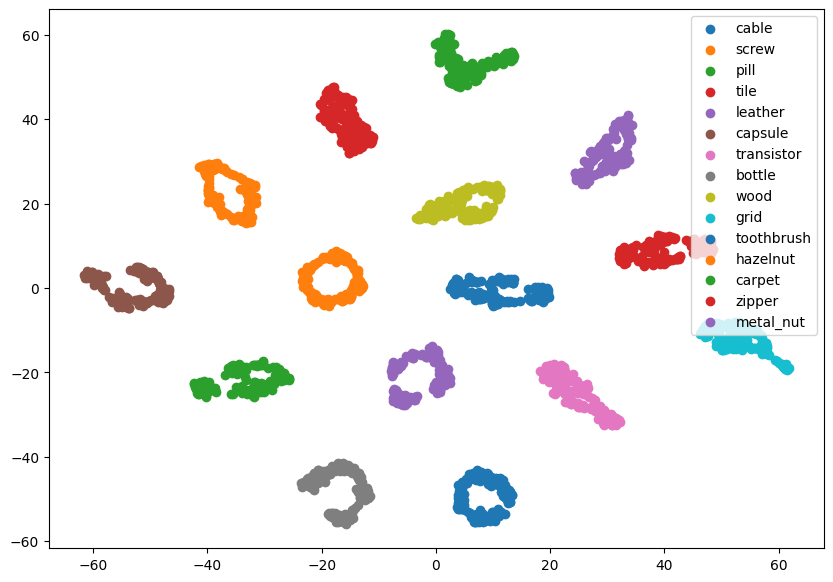

In [4]:
def load_model_weights(model, path):
    weight = torch.load(path)
    model.load_state_dict(weight)
    model.cuda()
    model.train()

def extract_features(model, dataloader, device):
    feature_list = []
    with torch.no_grad():
        for imgs, labels, clslabels, gts in dataloader:
            en_output, de_output = model(imgs.to(device))
            B, C, H, W = de_output[1].shape
            features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
            feature_list.append(features)
    return np.concatenate(feature_list)

def load_model_and_extract_features(model, model_weight_paths, loader_dict, device='cuda'):
    cln_features = {}

    for path in model_weight_paths:
        cln = path.split('/')[-1].split('_')[0]
        if cln =='metal':
            cln = 'metal_nut'
        load_model_weights(model, path)
        
        trainloader = loader_dict[cln]['train']
        features = extract_features(model, testloader, device)
        
        cln_features[cln] = features

    return cln_features


def tsne_transform(data, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data)
    return transformed_data

cln_features = load_model_and_extract_features(model,model_weight,loader_dict)
num_clns = {k:len(v) for k, v in cln_features.items()}

features = np.concatenate(list(cln_features.values()))
transformed_features = tsne_transform(features)

s = 0 

plt.figure(figsize=(10,7))
for k,v in num_clns.items():
    f = s+v 
    
    plt.scatter(
        transformed_features[s:f,0],
        transformed_features[s:f,1],
        label = k
    )
    s =f 
    
plt.legend(loc='upper right')
plt.show()

/tmp/ipykernel_445958/3498554807.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(path)


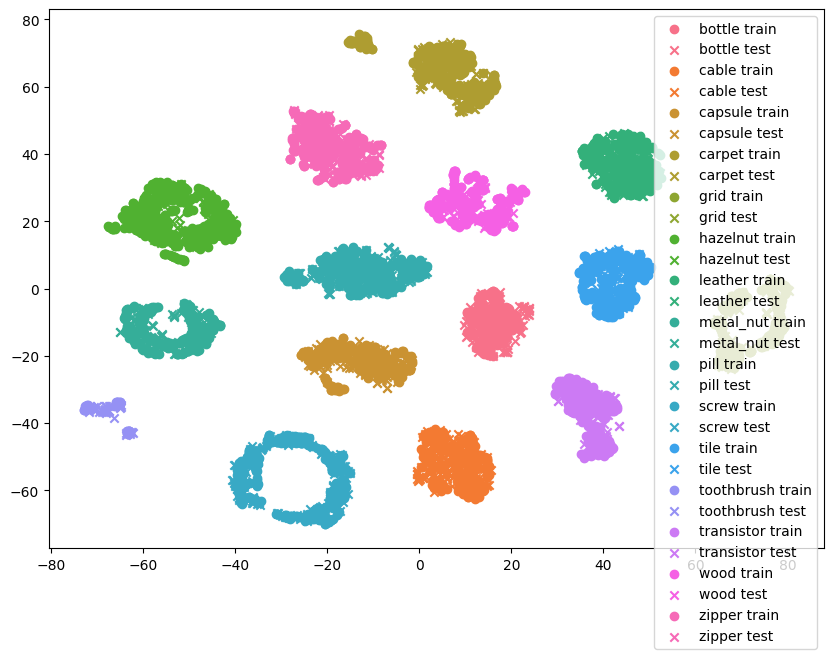

In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def load_model_weights(model, path):
    weight = torch.load(path)
    model.load_state_dict(weight)
    model.cuda()
    model.train()

def extract_features(model, dataloader, device, train='train'):
    feature_list = []
    with torch.no_grad():
        if train == 'train':
            for imgs, labels, clslabels in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
        else:
            for imgs, labels, clslabels, gts in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
    return np.concatenate(feature_list)


def load_model_and_extract_features(model, model_weight_paths, loader_dict, device='cuda'):
    cln_features = {}
    for path in model_weight_paths:
        cln = path.split('/')[-1].split('_')[0]
        if cln == 'metal':
            cln = 'metal_nut'
        load_model_weights(model, path)
        trainloader = loader_dict[cln]['train']
        testloader = loader_dict[cln]['test']
        train_features = extract_features(model, trainloader, device,train='train')
        test_features = extract_features(model, testloader, device,train='test')
        cln_features[cln] = {'train': train_features, 'test': test_features}
    return cln_features

def tsne_transform(data, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data)
    return transformed_data

from glob import glob 
method = ['ReverseDistillation']
continual = ['False']
online = ['False']

for m in method:
    for c in continual:
        for o in online:
            save_path = f'./results/{m}/MVTecAD/baseline_EMPTY-Continual_{c}-online_{o}/seed_42/model_weight/*'
            model_weight = glob(save_path)

# 모델, 가중치 파일 경로 리스트(model_weight), loader_dict, 그리고 device가 이미 정의되었다고 가정
cln_features = load_model_and_extract_features(model, model_weight, loader_dict)

# 모든 클래스에 대해 train과 test feature를 하나의 배열로 합치고, 각각의 레이블과 데이터 타입 정보를 기록
features_list = []
labels_list = []
data_type_list = []  # 'train' 또는 'test'
for cln, feats in cln_features.items():
    train_feats = feats['train']
    test_feats = feats['test']
    features_list.append(train_feats)
    features_list.append(test_feats)
    labels_list.extend([cln] * len(train_feats))
    labels_list.extend([cln] * len(test_feats))
    data_type_list.extend(['train'] * len(train_feats))
    data_type_list.extend(['test'] * len(test_feats))

all_features = np.concatenate(features_list)
transformed_features = tsne_transform(all_features)

plt.figure(figsize=(10, 7))
unique_classes = sorted(set(labels_list))
colors = sns.color_palette("husl", len(unique_classes))
color_map = {cln: colors[i] for i, cln in enumerate(unique_classes)}

for cln in unique_classes:
    idx_train = [i for i, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cln and dtype == 'train']
    idx_test  = [i for i, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cln and dtype == 'test']
    plt.scatter(transformed_features[idx_train, 0], transformed_features[idx_train, 1],
                color=color_map[cln], marker='o', label=f"{cln} train")
    plt.scatter(transformed_features[idx_test, 0], transformed_features[idx_test, 1],
                color=color_map[cln], marker='x', label=f"{cln} test")

plt.legend(loc='upper right')
plt.show()

/tmp/ipykernel_445958/3400167993.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(path)
/tmp/ipykernel_445958/3400167993.py:8: FutureWarning: You are 

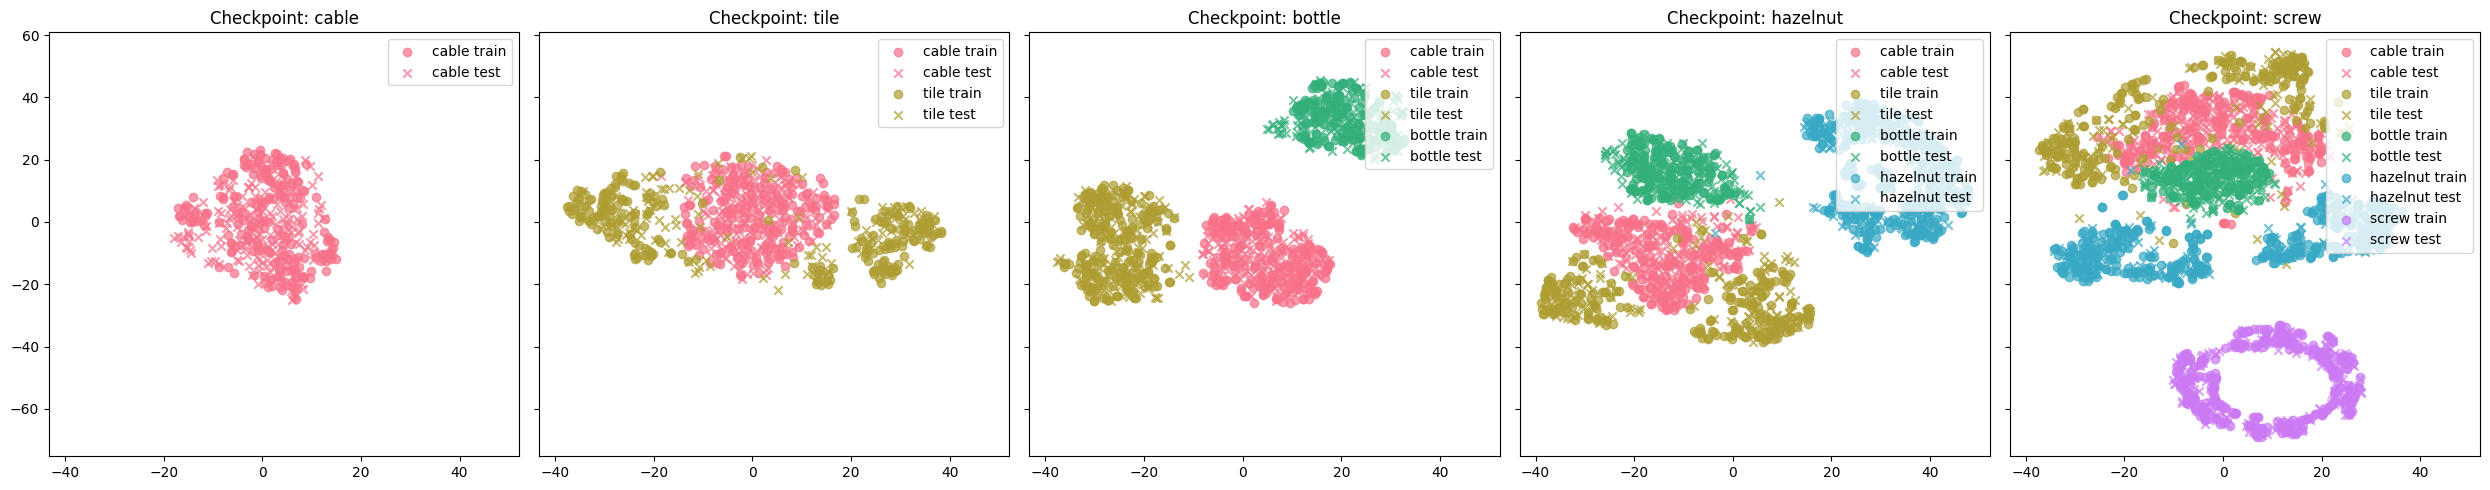

In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def load_model_weights(model, path):
    weight = torch.load(path)
    model.load_state_dict(weight)
    model.cuda()
    model.train()

def extract_features(model, dataloader, device, train='train'):
    feature_list = []
    with torch.no_grad():
        if train == 'train':
            for imgs, labels, clslabels in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
        else:
            for imgs, labels, clslabels, gts in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
    return np.concatenate(feature_list)

def tsne_transform(data, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data)
    return transformed_data

# Incremental learning order and selected checkpoints for plotting
incremental_order = ['grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw']
selected_checkpoints = ['cable', 'tile', 'bottle', 'hazelnut', 'screw']

# Build a mapping from class name to its weight file path from model_weight (assumed defined)
weight_dict = {}
for path in model_weight:
    cln = path.split('/')[-1].split('_')[0]
    if cln == 'metal':
        cln = 'metal_nut'
    if cln in selected_checkpoints:
        weight_dict[cln] = path

# Create color mapping for the selected checkpoints
colors = sns.color_palette("husl", len(selected_checkpoints))
color_map = {cl: colors[i] for i, cl in enumerate(selected_checkpoints)}

# Create 5 subplots (one for each selected checkpoint)
fig, axes = plt.subplots(1, len(selected_checkpoints), figsize=(25, 5), sharex=True, sharey=True)

device = 'cuda'  # or 'cpu'

for i, checkpoint in enumerate(selected_checkpoints):
    # Load the model weight corresponding to the current checkpoint
    load_model_weights(model, weight_dict[checkpoint])
    
    # Determine learned classes among the selected checkpoints up to the current one
    learned_classes = selected_checkpoints[:i+1]
    
    features_list = []
    labels_list = []
    data_type_list = []  # 'train' or 'test'
    
    for cl in learned_classes:
        trainloader = loader_dict[cl]['train']
        testloader = loader_dict[cl]['test']
        train_feats = extract_features(model, trainloader, device, train='train')
        test_feats = extract_features(model, testloader, device, train='test')
        features_list.append(train_feats)
        features_list.append(test_feats)
        labels_list.extend([cl] * len(train_feats))
        labels_list.extend([cl] * len(test_feats))
        data_type_list.extend(['train'] * len(train_feats))
        data_type_list.extend(['test'] * len(test_feats))
    
    combined_features = np.concatenate(features_list)
    tsne_emb = tsne_transform(combined_features)
    
    ax = axes[i]
    for cl in learned_classes:
        idx_train = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'train']
        idx_test  = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'test']
        ax.scatter(tsne_emb[idx_train, 0], tsne_emb[idx_train, 1],
                   color=color_map[cl], marker='o', label=f"{cl} train", alpha=0.7)
        ax.scatter(tsne_emb[idx_test, 0], tsne_emb[idx_test, 1],
                   color=color_map[cl], marker='x', label=f"{cl} test", alpha=0.7)
    
    ax.set_title(f"Checkpoint: {checkpoint}")
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def load_model_weights(model, path):
    weight = torch.load(path)
    model.load_state_dict(weight)
    model.cuda()
    model.train()

def extract_features(model, dataloader, device, train='train'):
    feature_list = []
    with torch.no_grad():
        if train == 'train':
            for imgs, labels, clslabels in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
        else:
            for imgs, labels, clslabels, gts in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
    return np.concatenate(feature_list)

def tsne_transform(data, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data)
    return transformed_data

# Incremental learning order and selected checkpoints for plotting
incremental_order = ['grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw']
selected_checkpoints = ['carpet','zipper','tile','transistor','leather','hazelnut','capsule','screw']

# Build a mapping from class name to its weight file path from model_weight (assumed defined)
weight_dict = {}
for path in model_weight:
    cln = path.split('/')[-1].split('_')[0]
    if cln == 'metal':
        cln = 'metal_nut'
    if cln in selected_checkpoints:
        weight_dict[cln] = path

# Create color mapping for the selected checkpoints
colors = sns.color_palette("husl", len(incremental_order))
color_map = {cl: colors[i] for i, cl in enumerate(incremental_order)}

# Create 5 subplots (one for each selected checkpoint)
fig, axes = plt.subplots(2, int(len(selected_checkpoints)/2), figsize=(40, 20), sharex=True, sharey=True)
axes = axes.flatten()


device = 'cuda'  # or 'cpu'
legend_handles  = [] 
for i, checkpoint in enumerate(selected_checkpoints):
    learned_classes = incremental_order[:incremental_order.index(checkpoint)+1]
    
    
    # features_list = []
    # labels_list = []
    # data_type_list = []  # 'train' or 'test'
    
    # load_model_weights(model, weight_dict[checkpoint])
    # for cl in learned_classes:
    #     trainloader = loader_dict[cl]['train']
    #     testloader = loader_dict[cl]['test']
    #     train_feats = extract_features(model, trainloader, device, train='train')
    #     test_feats = extract_features(model, testloader, device, train='test')
    #     features_list.append(train_feats)
    #     features_list.append(test_feats)
    #     labels_list.extend([cl] * len(train_feats))
    #     labels_list.extend([cl] * len(test_feats))
    #     data_type_list.extend(['train'] * len(train_feats))
    #     data_type_list.extend(['test'] * len(test_feats))
    
    
    ax = axes[i]
    for cl in learned_classes:
        idx_train = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'train']
        idx_test  = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'test']
        sc = ax.scatter(tsne_emb[idx_train, 0], tsne_emb[idx_train, 1],
                   color=color_map[cl], marker='o', label=f"{cl}", alpha=0.7)
        # ax.scatter(tsne_emb[idx_test, 0], tsne_emb[idx_test, 1],
        #            color=color_map[cl], marker='x', label=f"{cl} test", alpha=0.7)
    
    if i == 14:
        legend_handles.append(sc)
            
    ax.set_title(f"Checkpoint: {checkpoint}",weight='bold',fontsize=30)
fig.legend(handles=legend_handles, labels=[h.get_label() for h in legend_handles], 
           loc='upper right', fontsize=20, bbox_to_anchor=(1.1, 1.0))
plt.tight_layout()
plt.show()


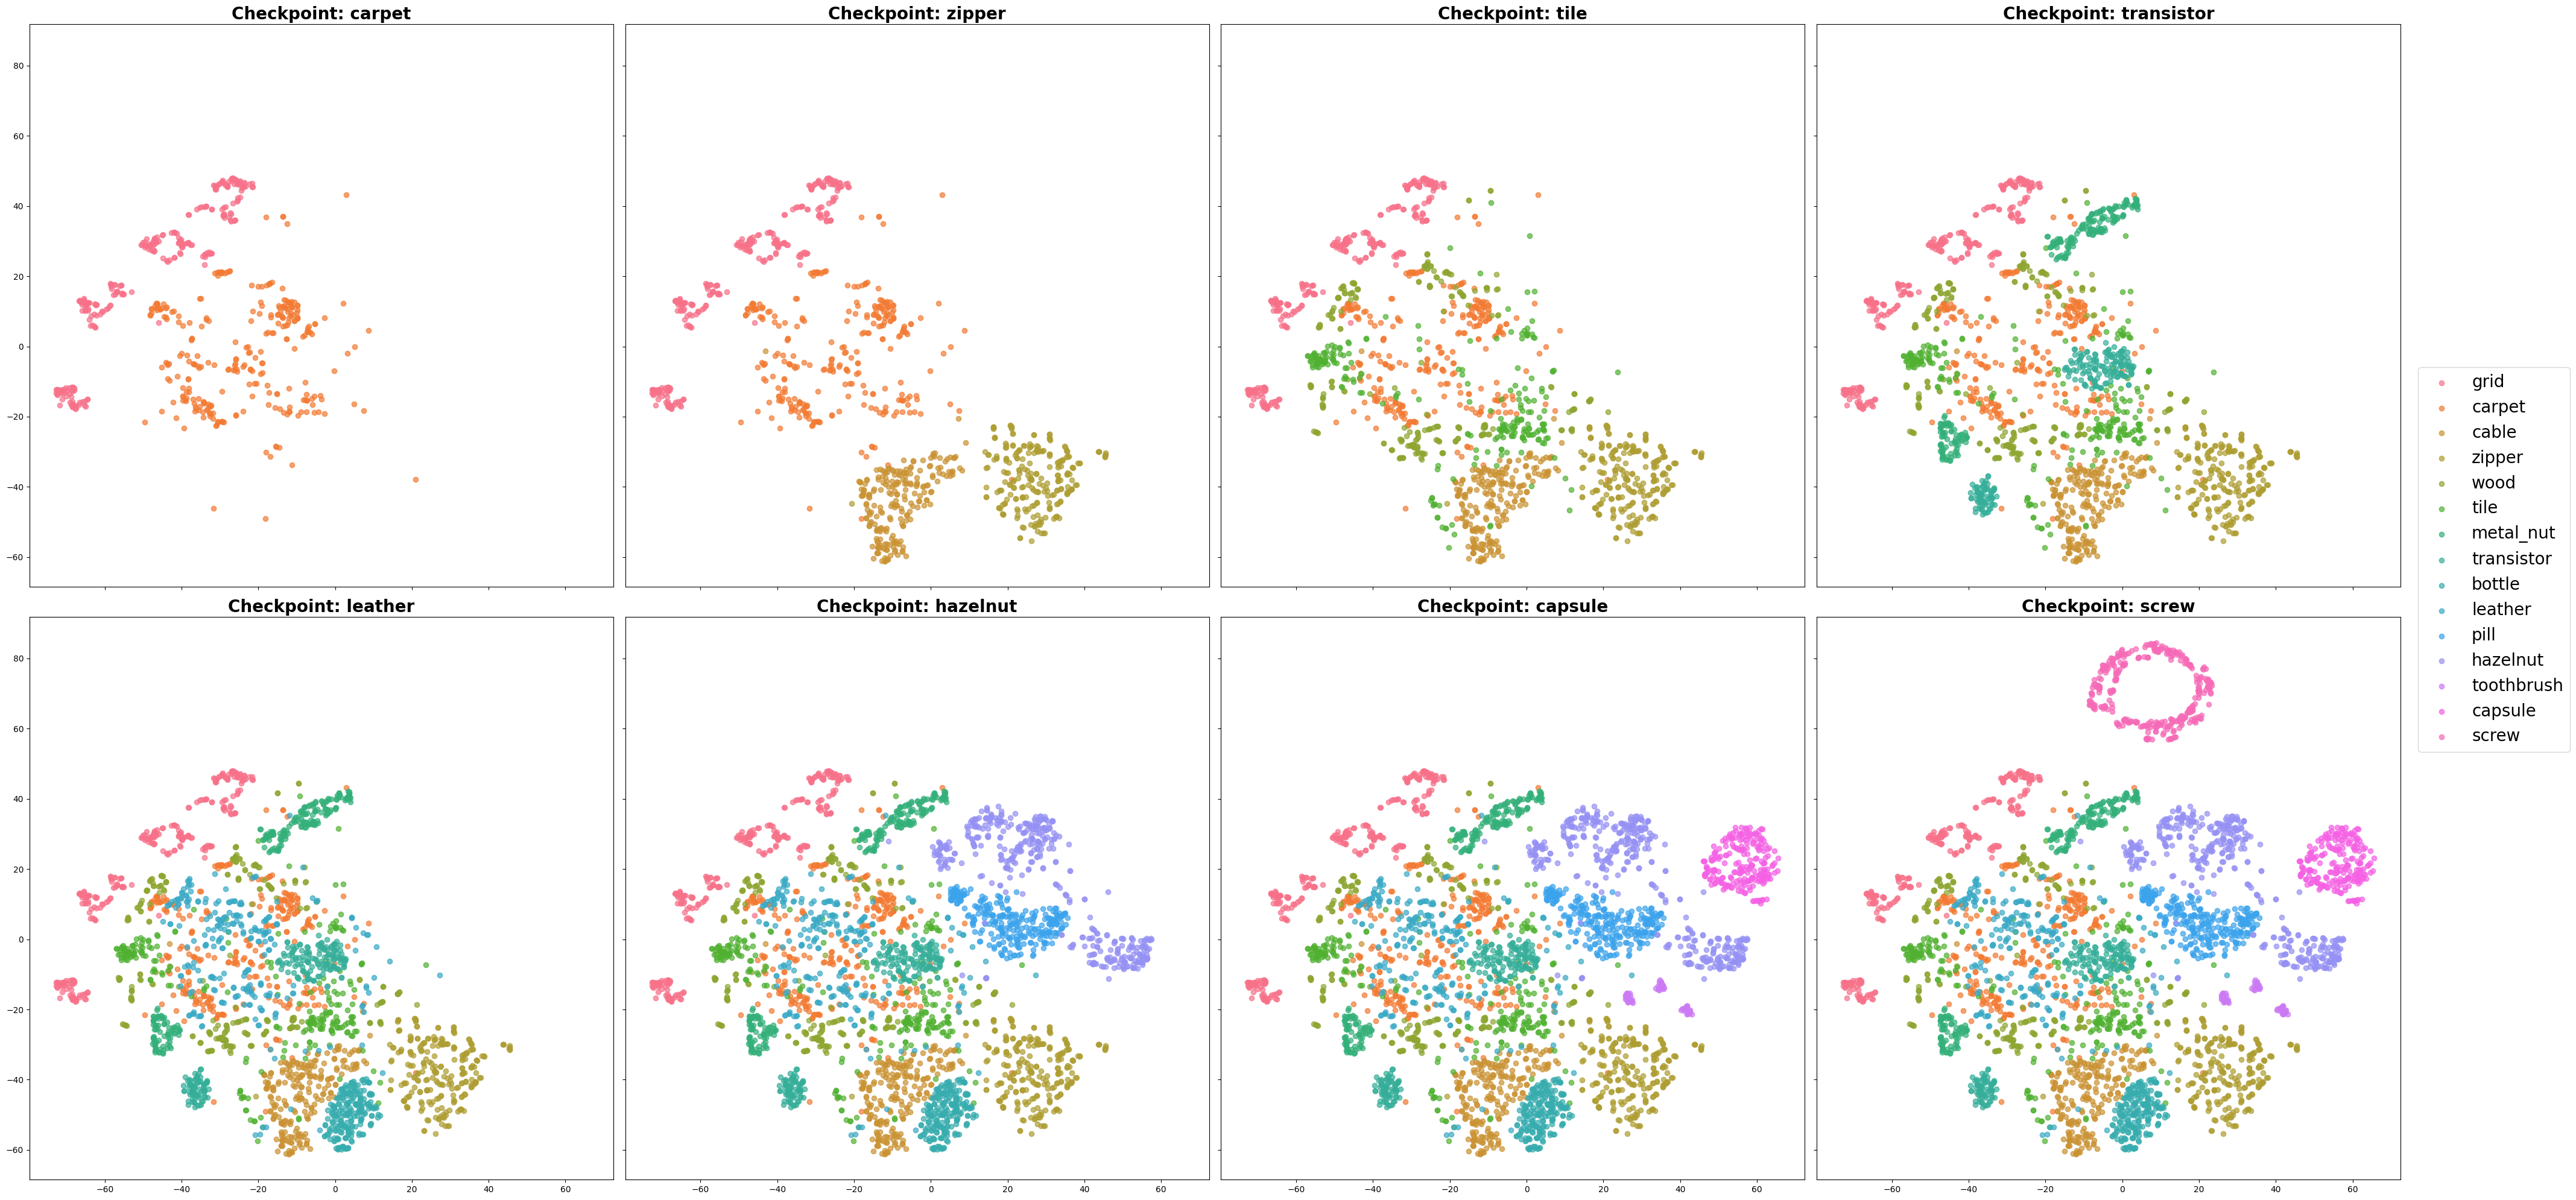

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def load_model_weights(model, path):
    weight = torch.load(path)
    model.load_state_dict(weight)
    model.cuda()
    model.train()

def extract_features(model, dataloader, device, train='train'):
    feature_list = []
    with torch.no_grad():
        if train == 'train':
            for imgs, labels, clslabels in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
        else:
            for imgs, labels, clslabels, gts in dataloader:
                en_output, de_output = model(imgs.to(device))
                B, C, H, W = de_output[1].shape
                features = de_output[1].reshape(B, C, -1).mean(-1).detach().cpu().numpy()
                feature_list.append(features)
    return np.concatenate(feature_list)

def tsne_transform(data, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data)
    return transformed_data

# Incremental learning order and selected checkpoints for plotting
incremental_order = ['grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw']
selected_checkpoints = ['carpet','zipper','tile','transistor','leather','hazelnut','capsule','screw']

# Build a mapping from class name to its weight file path from model_weight (assumed defined)
weight_dict = {}
for path in model_weight:
    cln = path.split('/')[-1].split('_')[0]
    if cln == 'metal':
        cln = 'metal_nut'
    if cln in selected_checkpoints:
        weight_dict[cln] = path

# Create color mapping for the selected checkpoints
colors = sns.color_palette("husl", len(incremental_order))
color_map = {cl: colors[i] for i, cl in enumerate(incremental_order)}

# Create 5 subplots (one for each selected checkpoint)
fig, axes = plt.subplots(2, int(len(selected_checkpoints)/2), figsize=(40, 20), sharex=True, sharey=True)
axes = axes.flatten()

device = 'cuda'  # or 'cpu'

legend_dict = {}  # 중복 방지를 위해 딕셔너리 사용

for i, checkpoint in enumerate(selected_checkpoints):
    learned_classes = incremental_order[:incremental_order.index(checkpoint)+1]

    ax = axes[i]
    for cl in learned_classes:
        idx_train = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'train']
        idx_test  = [j for j, (lbl, dtype) in enumerate(zip(labels_list, data_type_list)) if lbl == cl and dtype == 'test']
        sc = ax.scatter(tsne_emb[idx_train, 0], tsne_emb[idx_train, 1],
                         color=color_map[cl], marker='o', alpha=0.7)

        # 클래스가 처음 등장한 경우에만 legend_dict에 추가
        if cl not in legend_dict:
            legend_dict[cl] = sc

    ax.set_title(f"Checkpoint: {checkpoint}", weight='bold', fontsize=20)

# 전체 fig에 대한 범례 추가 (중복 제거)
fig.legend(handles=list(legend_dict.values()), labels=list(legend_dict.keys()), 
           loc='upper right', fontsize=20, bbox_to_anchor=(1.07, 0.7))

plt.tight_layout()
plt.show()
